### **Machine Learning Task: Clustering Customers**

Name: <font color="green">Althea Grace Concha</font>  
Section: <font color="green">3DSA</font>

In [79]:
# Import Libraries
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option("display.float_format",lambda x : '%.3f'%x)

<font color="#154360" style="font-size:26px;"><b>Data Dictionary</b></font>


| **Variable**  | **Description**                                                                                     |
| ------------- | --------------------------------------------------------------------------------------------------- |
| **InvoiceNo**   | Unique identifier for each transaction. If it starts with 'C', it indicates a canceled transaction. |
| **StockCode**   | Unique identifier for each product.                                                                 |
| **Description** | Name/description of the product.                                                                    |
| **Quantity**    | Number of product units sold per invoice.                                                           |
| **InvoiceDate** | Date and time when the transaction took place.                                                      |
| **UnitPrice**   | Price of a single product unit (in GBP).                                                            |
| **CustomerID**  | Unique identifier for each customer.                                                                |
| **Country**     | Name of the country where the customer resides.                                                     |


<font color="#154360" style="font-size:26px;"><b>📌 Data Import and Exploration</b></font>

In [80]:
retail_df = pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.550,17850.000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.390,17850.000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.750,17850.000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.390,17850.000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.390,17850.000,United Kingdom


In [81]:
retail_df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.850,12680.000,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.100,12680.000,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.150,12680.000,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.150,12680.000,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,09-12-2011 12:50,4.950,12680.000,France


In [82]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [83]:
retail_df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000,541909.000,406829.000
mean,9.552,4.611,15287.691
std,218.081,96.760,1713.600
min,-80995.000,-11062.060,12346.000
25%,1.000,1.250,13953.000
50%,3.000,2.080,15152.000
75%,10.000,4.130,16791.000
max,80995.000,38970.000,18287.000


<font color="#154360" style="font-size:26px;"><b>📌 Data Cleaning</b></font>

In [84]:
retail_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [85]:
retail_clean = retail_df.copy()

In [86]:
retail_clean = retail_df.copy()

# delete null data
retail_clean = retail_clean[retail_clean['CustomerID'].notnull()]

# fill missing descriptions with mode
retail_clean['Description'] = retail_clean['Description'].fillna(retail_clean['Description'].mode()[0])

# filter returns, canceled items
retail_clean = retail_clean[retail_clean['Quantity'] > 0]

# filter free/gift/test/invalid entries
retail_clean = retail_clean[retail_clean['UnitPrice'] > 0]
retail_clean = retail_clean[~retail_clean["InvoiceNo"].str.contains("C", na=False)]

In [87]:
retail_clean['InvoiceDate'] = pd.to_datetime(retail_clean['InvoiceDate'], format='%d-%m-%Y %H:%M')

In [88]:
retail_clean['TotalPrice'] = retail_clean['Quantity'] * retail_clean['UnitPrice']

<font color="#154360" style="font-size:26px;"><b>📌 Data Preparation and Adding RFM (Recency, Frequency, Monetary) </b></font>

In [89]:
retail_clean.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.550,17850.000,United Kingdom,15.300
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.750,17850.000,United Kingdom,22.000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340


In [90]:
retail_clean["InvoiceDate"].max()

Timestamp('2011-12-09 12:50:00')

In [91]:
today_date = retail_clean['InvoiceDate'].max() + pd.Timedelta(days=1)

In [92]:
rfm = (retail_clean.groupby('CustomerID')
       .agg({'InvoiceDate': lambda x: (today_date - x.max()).days,
             'InvoiceNo': lambda x: x.nunique(),
             'TotalPrice': lambda x: x.sum()}))

In [93]:
rfm.head()

,InvoiceDate,InvoiceNo,TotalPrice
CustomerID,,,
12346.000,326,1,77183.600
12347.000,2,7,4310.000
12348.000,75,4,1797.240
12349.000,19,1,1757.550
12350.000,310,1,334.400


In [94]:
rfm.columns=['recency','frequency','monetary']

In [95]:
rfm.head()

,recency,frequency,monetary
CustomerID,,,
12346.000,326,1,77183.600
12347.000,2,7,4310.000
12348.000,75,4,1797.240
12349.000,19,1,1757.550
12350.000,310,1,334.400


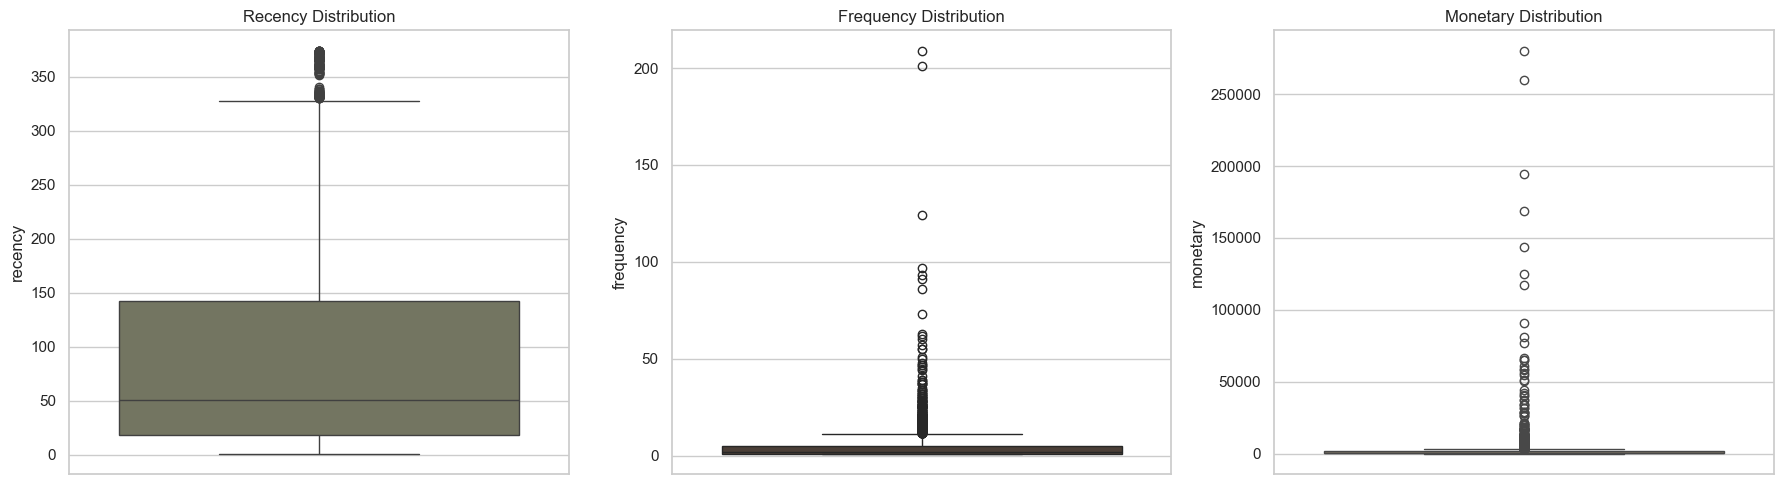

In [96]:
plt.figure(figsize=(18, 5))
sns.set(style='whitegrid')

# Recency
plt.subplot(1, 3, 1)
sns.boxplot(y=rfm['recency'], color='#76785E')
plt.title('Recency Distribution')

# Frequency
plt.subplot(1, 3, 2)
sns.boxplot(y=rfm['frequency'], color='#4E3F34')
plt.title('Frequency Distribution')

# Monetary
plt.subplot(1, 3, 3)
sns.boxplot(y=rfm['monetary'], color='#8C7F65')
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

In [97]:
def remove_outliers_iqr(retail_df, column):
    Q1 = retail_df[column].quantile(0.25)
    Q3 = retail_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return retail_df[(retail_df[column] >= lower_bound) & (retail_df[column] <= upper_bound)]

In [98]:
wo_outliers = rfm.copy()

for col in ['recency', 'frequency', 'monetary']:
    wo_outliers = remove_outliers_iqr(wo_outliers, col)

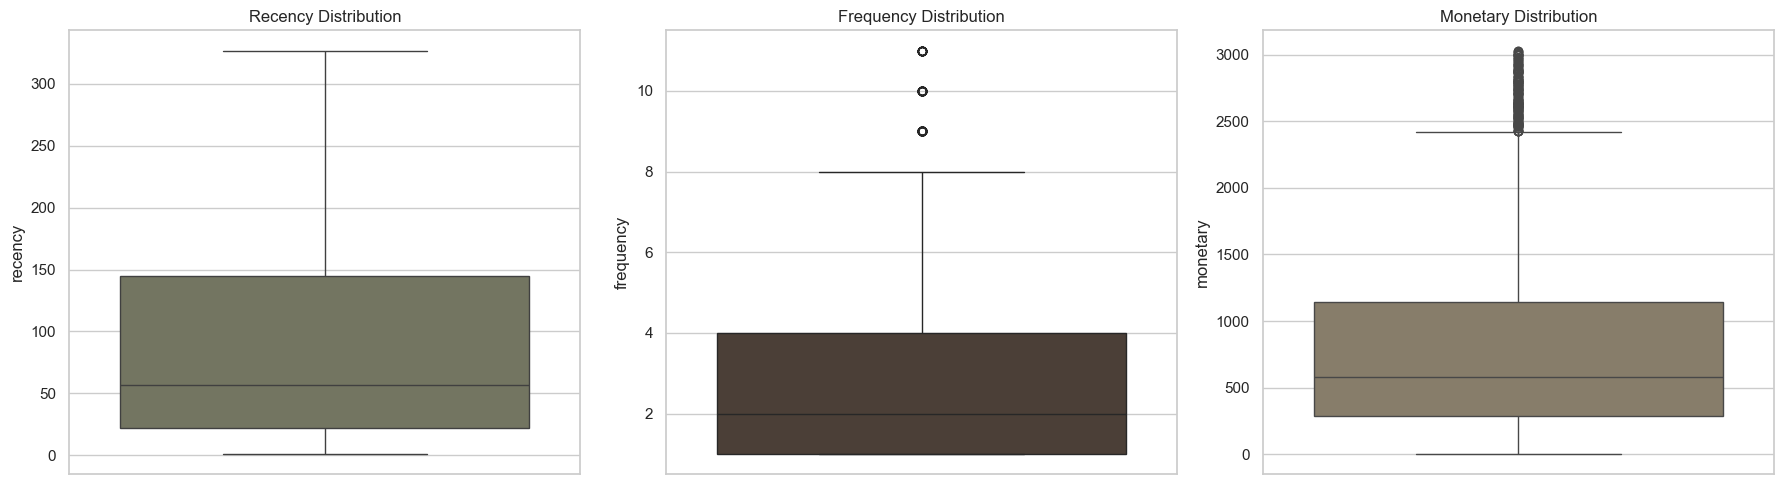

In [99]:
plt.figure(figsize=(18, 5))
sns.set(style='whitegrid')

# Recency
plt.subplot(1, 3, 1)
sns.boxplot(y=wo_outliers['recency'], color='#76785E')
plt.title('Recency Distribution')

# Frequency
plt.subplot(1, 3, 2)
sns.boxplot(y=wo_outliers['frequency'], color='#4E3F34')
plt.title('Frequency Distribution')

# Monetary
plt.subplot(1, 3, 3)
sns.boxplot(y=wo_outliers['monetary'], color='#8C7F65')
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

In [100]:
# Scale data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(wo_outliers[['recency', 'frequency', 'monetary']])

<font color="#154360" style="font-size:26px;"><b>🔍 Where are you K?</b></font>

*Finding the optimal number of K*

To determine the optimal number of clusters (K) for segmenting our customer base using RFM (Recency, Frequency, Monetary) analysis, I employed both the Elbow Method and the Silhouette Method.

<font color="#B4431E" style="font-size:22px;"><b> A. Using the Elbow Method 💪</b></font>

In [101]:
import plotly.express as px
import pandas as pd
from sklearn.cluster import KMeans

# Compute SSE for each k
k_values = list(range(1, 11))
sse = [KMeans(n_clusters=k, random_state=42).fit(rfm_scaled).inertia_
       for k in k_values]

plot_df = pd.DataFrame({'Number of Clusters (k)': k_values, 'SSE': sse})

fig = px.line(
    plot_df,
    x='Number of Clusters (k)',
    y='SSE',
    markers=True,
    title='SSE vs Number of Clusters (Elbow Method)',
    labels={'SSE': 'Sum of Squared Errors (SSE)'}
)

fig.update_xaxes(dtick=1)        

fig.show()

<font color="#516B2B" style="font-size:22px;"><b>💡 Insights:</b></font>

The Elbow Method involves plotting the Sum of Squared Errors (SSE) against various values of K. As K increases, SSE typically decreases, indicating tighter clusters. However, beyond a certain point, the rate of decrease sharply diminishes, forming an "elbow" in the graph. This point suggests that adding more clusters doesn't significantly improve the model. In our analysis, the elbow was observed at K = 3, indicating that three clusters capture the most significant structure in the data without overfitting.

<font color="#B4431E" style="font-size:22px;"><b> B. Using the Silhouette Score 👤</b></font>

In [102]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px
import pandas as pd

# Store silhouette scores for k = 2 to 10
silhouette_scores = []
k_values = list(range(2, 11))

print("Silhouette Scores by k:")
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(rfm_scaled)
    labels = kmeans.labels_
    score = silhouette_score(rfm_scaled, labels)
    silhouette_scores.append(score)
    print(f"  k = {k:2d} → Silhouette Score = {score:.4f}")

# Create DataFrame for plotting
silhouette_df = pd.DataFrame({
    'Number of Clusters (k)': k_values,
    'Silhouette Score': silhouette_scores
})

# Plot with Plotly
fig = px.line(
    silhouette_df,
    x='Number of Clusters (k)',
    y='Silhouette Score',
    markers=True,
    title='Silhouette Score vs Number of Clusters',
    labels={'Silhouette Score': 'Silhouette Score'}
)
fig.show()

Silhouette Scores by k:
  k =  2 → Silhouette Score = 0.4406
  k =  3 → Silhouette Score = 0.4530
  k =  4 → Silhouette Score = 0.4141
  k =  5 → Silhouette Score = 0.3644
  k =  6 → Silhouette Score = 0.3633
  k =  7 → Silhouette Score = 0.3649
  k =  8 → Silhouette Score = 0.3447
  k =  9 → Silhouette Score = 0.3404
  k = 10 → Silhouette Score = 0.3494


<font color="#516B2B" style="font-size:22px;"><b>💡 Insights:</b></font>

The Silhouette Method assesses how similar an object is to its own cluster compared to other clusters. Silhouette scores range from -1 to 1, with higher values indicating better-defined clusters. By calculating the average silhouette score for different K values, we found that K = 3 yielded the highest score. This suggests that three clusters provide the most cohesive and well-separated groupings in our dataset.

Combining insights from both methods, K = 3 emerges as the optimal number of clusters, balancing model simplicity with effective segmentation.

<font color="#154360" style="font-size:26px;"><b>📌 Data Visualizations and Insights</b></font>

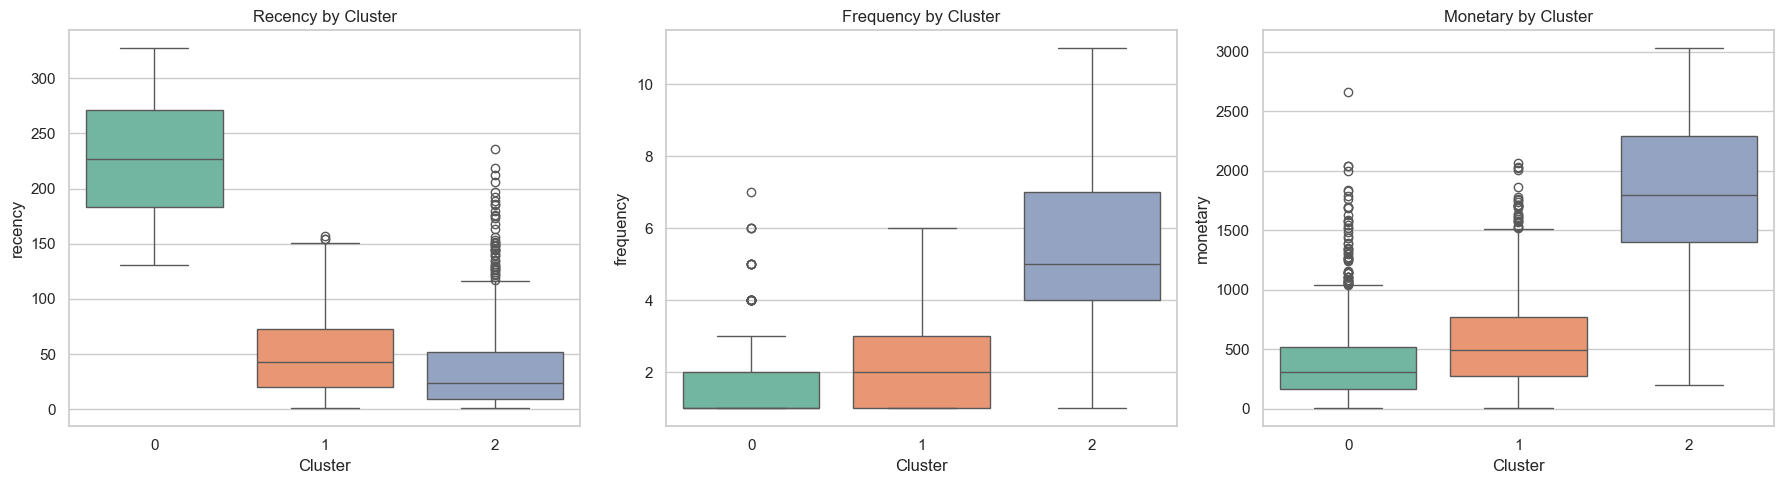

In [103]:
from sklearn.cluster import KMeans

best_k = 3 
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(rfm_scaled)   

wo_outliers = wo_outliers.reset_index(drop=True)  # ensure same indexing
wo_outliers['Cluster'] = labels

plt.figure(figsize=(18, 5))
sns.set(style='whitegrid')

# Recency
plt.subplot(1, 3, 1)
sns.boxplot(x='Cluster', y='recency', data=wo_outliers, palette='Set2')
plt.title('Recency by Cluster')

# Frequency
plt.subplot(1, 3, 2)
sns.boxplot(x='Cluster', y='frequency', data=wo_outliers, palette='Set2')
plt.title('Frequency by Cluster')

# Monetary
plt.subplot(1, 3, 3)
sns.boxplot(x='Cluster', y='monetary', data=wo_outliers, palette='Set2')
plt.title('Monetary by Cluster')

plt.tight_layout()
plt.show()

<font color="#516B2B" style="font-size:22px;"><b>📊 RFM Cluster Visualization Report</b></font>

In the **Recency plot**, Cluster 0 has the highest recency values, indicating that these customers have not transacted in a long time. In contrast, Clusters 1 and 2 have much lower recency, with Cluster 2 showing the most recent activity, suggesting highly engaged customers.

The **Frequency plot** highlights that Cluster 2 customers purchase more frequently than the others, with a notably higher median and broader upper range. Cluster 0 has the lowest purchase frequency, reinforcing its label as an inactive group, while Cluster 1 falls in between, showing moderate but consistent engagement.

The **Monetary plot** further emphasizes the value of Cluster 2, whose members spend significantly more than other groups. Their spending range and upper quartile are markedly higher, making them the highest-value segment. Cluster 1 shows moderate spending behavior, whereas Cluster 0 again displays the lowest monetary contribution.
These visualizations support the statistical findings of the RFM segmentation and reaffirm that Cluster 2 represents the most active and profitable customers, Cluster 1 has potential for nurturing, and Cluster 0 requires re-engagement or pruning.

In [104]:
# Recency table
recency_table = wo_outliers.groupby('Cluster')['recency'] \
    .agg(count='count', mean='mean', median='median') \
    .round(2)
print("Recency by Cluster")
display(recency_table)

# Frequency table
frequency_table = wo_outliers.groupby('Cluster')['frequency'] \
    .agg(count='count', mean='mean', median='median') \
    .round(2)
print("\nFrequency by Cluster")
display(frequency_table)

# Monetary table
monetary_table = wo_outliers.groupby('Cluster')['monetary'] \
    .agg(count='count', mean='mean', median='median') \
    .round(2)
print("\nMonetary by Cluster")
display(monetary_table)


Recency by Cluster


,count,mean,median
Cluster,,,
0,906,227.940,227.000
1,1876,49.610,43.000
2,820,37.140,24.000



Frequency by Cluster


,count,mean,median
Cluster,,,
0,906,1.490,1.000
1,1876,2.030,2.000
2,820,5.680,5.000



Monetary by Cluster


,count,mean,median
Cluster,,,
0,906,404.720,309.920
1,1876,558.530,490.690
2,820,1847.400,1797.680


<font color="#516B2B" style="font-size:22px;"><b>📝 Customer Segmentation Report: RFM Analysis</b></font>

| Cluster | Recency (days) | Frequency (purchases) | Monetary (£) | Description                                   |  Size |
| :-----: | :------------: | :-------------------: | :----------: | --------------------------------------------- | :---: |
|  **0**  |   228 (high)   |       1.5 (low)       |   405 (low)  | **Dormant, low-value** customers              |  906  |
|  **1**  |    50 (mid)    |       2.0 (mid)       |   559 (mid)  | **Occasional** shoppers with growth potential | 1,876 |
|  **2**  |    37 (low)    |       5.7 (high)      | 1,847 (high) | **Loyal, high-value** customers               |  820  |

Based on my analysis of customer behavior using RFM (Recency, Frequency, Monetary) metrics, I segmented our customer base into three distinct clusters using K-Means clustering, with K = 3 determined as optimal through the Elbow Method and Silhouette Score. The first segment, Cluster 0, represents dormant, low-value customers whose last purchase was over seven months ago, averaging only 1.5 purchases and £405 in total spending. The second segment, Cluster 1, includes occasional shoppers with moderate recency (about 50 days since the last purchase), a slightly higher frequency (2.0 purchases), and £559 in spending, indicating strong potential for growth with the right engagement strategies. The most valuable group, Cluster 2, consists of loyal and high-spending customers who purchase frequently (5.7 times on average), spend significantly (£1,847), and have shopped recently (within 37 days). These findings suggest three tailored approaches: reward and retain Cluster 2 through VIP programs and exclusives, nurture Cluster 1 with personalized promotions to increase engagement, and selectively re-engage or de-prioritize Cluster 0 depending on responsiveness. This segmentation provides a clear strategic direction for resource allocation and customer relationship management.